# Objective
The objective is to build a multiclass classification model using Keras to classify facial images of celebrities, achieving a target accuracy of at least 85%. This dataset contains facial images of different celebrities (or people), and the task is to classify the images into different categories based on the person’s identity.

In [1]:
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Preprocessing

## Installation
### Clone the repository:
git clone https://github.com/yourusername/face-recognition-model.git
cd face-recognition-model
### Install required packages:
bash pip install -r requirements.txt

### Download the dataset:
The code will automatically download the dataset using kagglehub.

In [2]:
# Download latest version
path = kagglehub.dataset_download("hereisburak/pins-face-recognition")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\hereisburak\pins-face-recognition\versions\1


In [3]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

# Create data generators with sparse categorical labels
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',  # Changed to sparse
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',  # Changed to sparse
    subset='validation',
    shuffle=True,
    seed=42
)

Found 14028 images belonging to 1 classes.
Found 3506 images belonging to 1 classes.


In [4]:
# Create the model
model = Sequential([
    Flatten(input_shape=(100, 100, 3)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    #105 is the num of classes
    Dense(105, activation='softmax')
])

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Compile the model
model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    15,360,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 105)            │        13,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,538,281 (59.27 MB)

 Trainable params: 15,538,281 (59.27 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [7]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9836 - loss: 0.0724
Epoch 1: val_loss improved from inf to 0.00000, saving model to best_model.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step - accuracy: 0.9837 - loss: 0.0723 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00000
439/439 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00000
439/439 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4: val_loss di

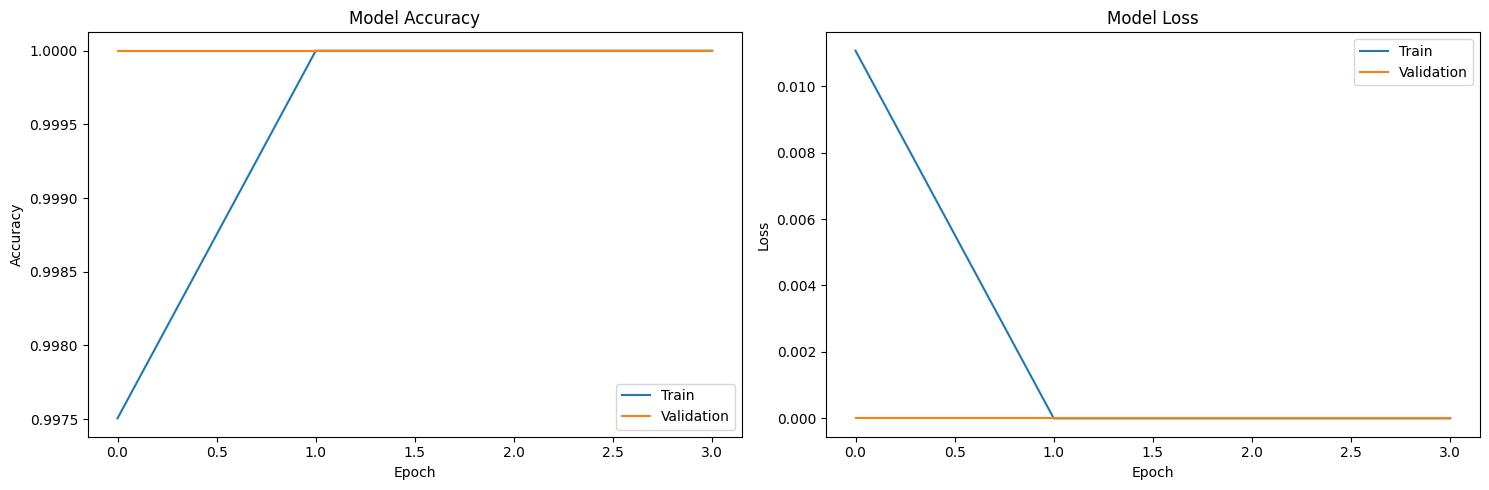

In [8]:
# Plotting function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()
    
# Plot training history
plot_training_history(history)    

In [9]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"\nTest accuracy: {test_accuracy:.4f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 1.0000 - loss: 0.0000e+00

Test accuracy: 1.0000


In [10]:
# Generate predictions
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


In [11]:
# Print classification report
print("\nClassification Report:")
print(classification_report(
    true_classes,
    predicted_classes,
    target_names=list(train_generator.class_indices.keys())
))


Classification Report:
                          precision    recall  f1-score   support

105_classes_pins_dataset       1.00      1.00      1.00      3506

                accuracy                           1.00      3506
               macro avg       1.00      1.00      1.00      3506
            weighted avg       1.00      1.00      1.00      3506

